In [178]:
%matplotlib inline
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import string

# 0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ
characters = string.digits + string.ascii_uppercase
width, height, n_len, n_class = 120, 60, 4, len(characters)
generator = ImageCaptcha(width=width, height=height)

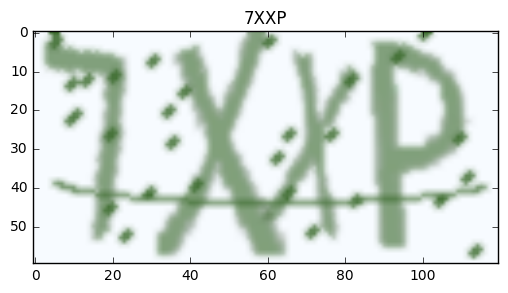

In [3]:
# test
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)
plt.imshow(img)
plt.title(random_str)

In [4]:
def gen(batch_size=32):
    X = np.zeros((batch_size, height, width, 3), dtype=np.uint8)
    y = [np.zeros((batch_size, n_class), dtype=np.uint8) for i in range(n_len)]
    generator = ImageCaptcha(width=width, height=height)
    while True:
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = generator.generate_image(random_str)
            for j, ch in enumerate(random_str):
                y[j][i, :] = 0
                y[j][i, characters.find(ch)] = 1
        yield X, y

In [167]:
def decode(y):
    acc = np.cumprod(np.max(y, axis=2)[0:])[-1]
    y = np.argmax(np.array(y), axis=2)[:,0]
    title = ''.join([characters[x] for x in y])
    return '%s %.6f' % (title, acc)

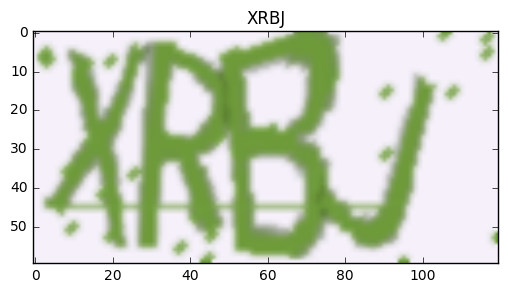

In [6]:
# test
X, y = next(gen(1))
plt.imshow(X[0])
plt.title(decode(y))

In [7]:
from keras.models import *
from keras.layers import *

input_tensor = Input((height, width, 3))
x = input_tensor
for i in range(3): # keras2
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = Conv2D(32*2**i, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dropout(0.25)(x)
# 4个分类器多输出
x = [Dense(n_class, activation='softmax', name='c%d'%(i+1))(x) for i in range(4)]

model = Model(inputs=input_tensor, outputs=x)
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

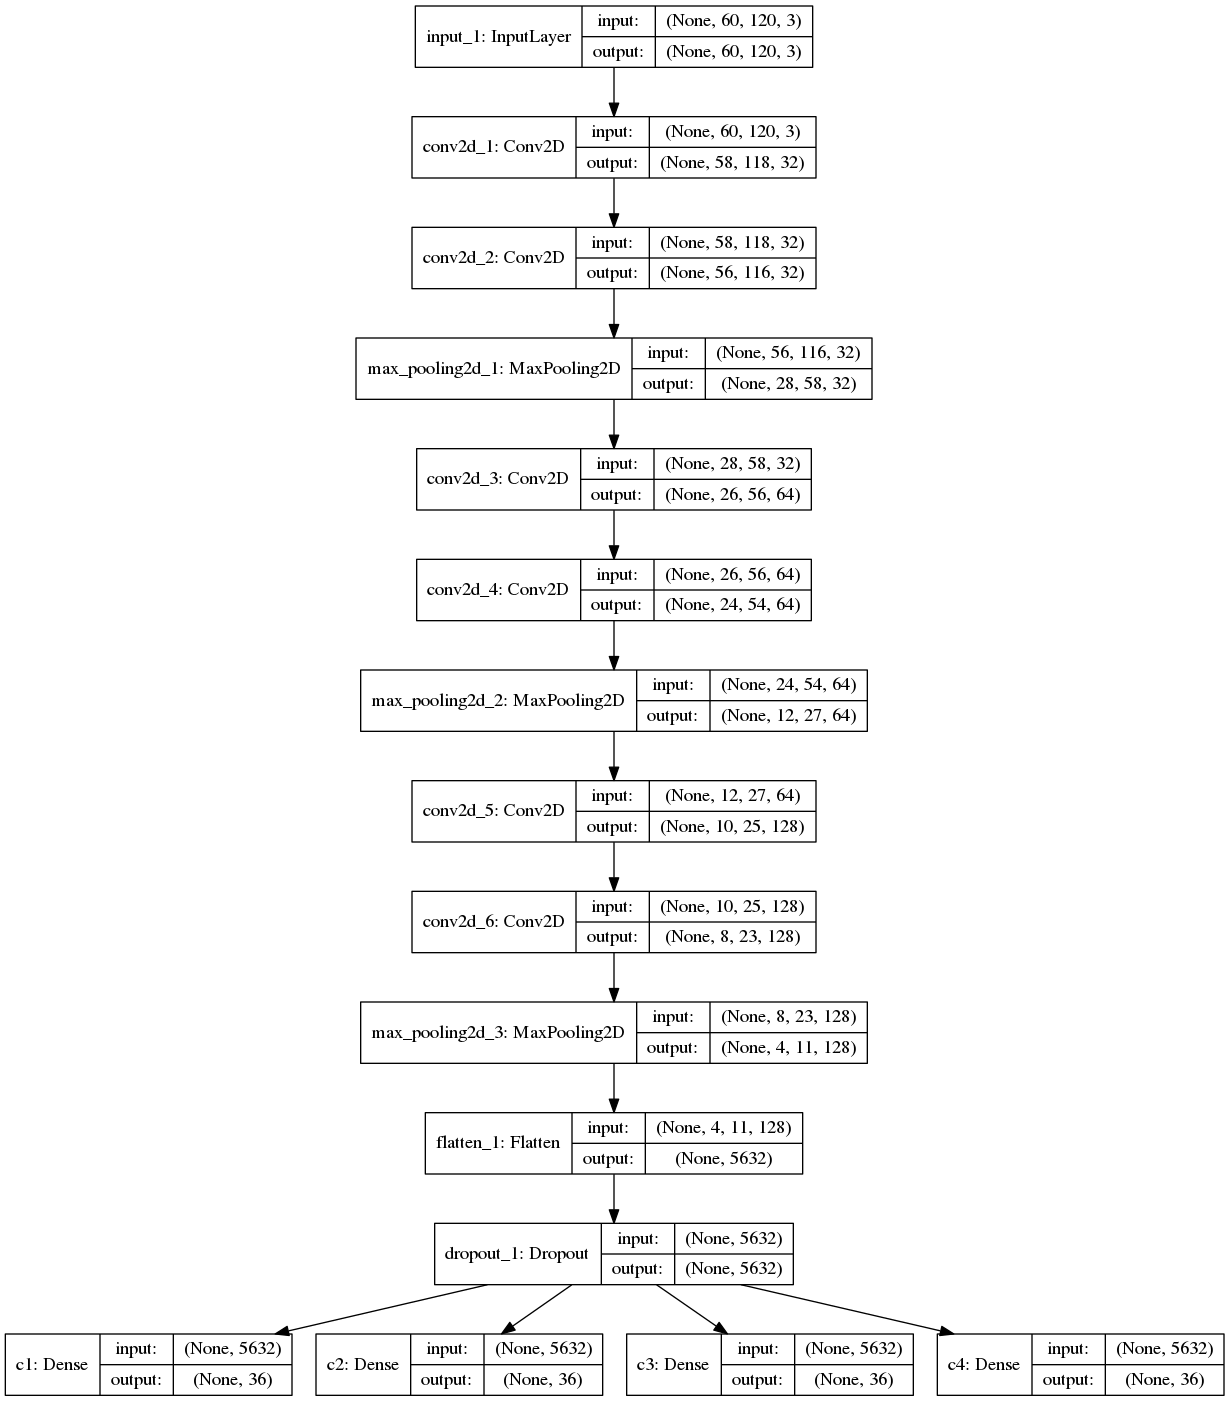

In [8]:
from keras.utils import plot_model
from IPython.display import Image
# sudo pip install graphviz(安装接口)
# sudo apt-get install graphviz(安装软件本身)
# sudo pip install pydot
plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')

In [8]:
model.fit_generator(gen(), steps_per_epoch=1000, epochs=10, workers=2, use_multiprocessing=True, 
                    validation_data=gen(), validation_steps=200) # keras2
# 多进程 workers=2, use_multiprocessing=True pickle_safe

/home/littleredhat/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2057: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10
 999/1000 [============================>.] - ETA: 0s - loss: 11.0387 - c1_loss: 2.5382 - c2_loss: 2.6943 - c3_loss: 2.8540 - c4_loss: 2.9522 - c1_acc: 0.4198 - c2_acc: 0.3790 - c3_acc: 0.3370 - c4_acc: 0.3131

/home/littleredhat/anaconda3/lib/python3.5/site-packages/keras/engine/training.py:2215: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


1000/1000 [==============================] - 843s 843ms/step - loss: 11.0315 - c1_loss: 2.5366 - c2_loss: 2.6923 - c3_loss: 2.8523 - c4_loss: 2.9503 - c1_acc: 0.4200 - c2_acc: 0.3795 - c3_acc: 0.3373 - c4_acc: 0.3134 - val_loss: 3.4483 - val_c1_loss: 0.5954 - val_c2_loss: 0.7562 - val_c3_loss: 1.0094 - val_c4_loss: 1.0873 - val_c1_acc: 0.8075 - val_c2_acc: 0.7645 - val_c3_acc: 0.6922 - val_c4_acc: 0.6767
Epoch 2/10
1000/1000 [==============================] - 823s 823ms/step - loss: 2.7318 - c1_loss: 0.4364 - c2_loss: 0.6134 - c3_loss: 0.7994 - c4_loss: 0.8826 - c1_acc: 0.8570 - c2_acc: 0.8027 - c3_acc: 0.7551 - c4_acc: 0.7335 - val_loss: 1.6111 - val_c1_loss: 0.2149 - val_c2_loss: 0.3402 - val_c3_loss: 0.5087 - val_c4_loss: 0.5473 - val_c1_acc: 0.9278 - val_c2_acc: 0.8880 - val_c3_acc: 0.8486 - val_c4_acc: 0.8309
Epoch 3/10
1000/1000 [==============================] - 823s 823ms/step - loss: 1.5924 - c1_loss: 0.2252 - c2_loss: 0.3435 - c3_loss: 0.4843 - c4_loss: 0.5394 - c1_acc: 0.925

In [9]:
# save
model.save('captcha_model.h5')

In [10]:
from keras.models import load_model
model = load_model('captcha_model.h5')

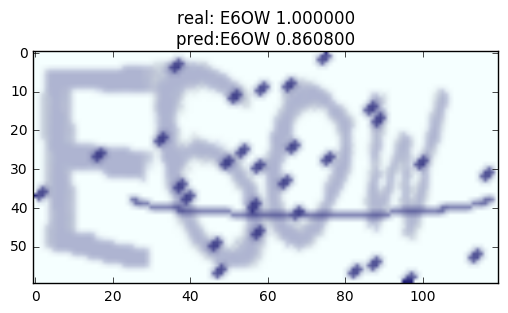

In [173]:
X, y = next(gen(1))
y_pred = model.predict(X)
plt.title('real: %s\npred:%s'%(decode(y), decode(y_pred)))
plt.imshow(X[0], cmap='gray')

In [ ]:
# 生成对抗样本
target_idx      = model.predict(original_array).argmax()
target          = to_categorical(target_idx, 1000)
target_variable = K.variable(target)
loss            = metrics.categorical_crossentropy(model.output, target_variable)
gradients       = K.gradients(loss, model.input)
get_grad_values = K.function([model.input], gradients)
grad_values     = get_grad_values([original_array])[0]

In [181]:
x, y = next(gen(1))

In [184]:
import cv2

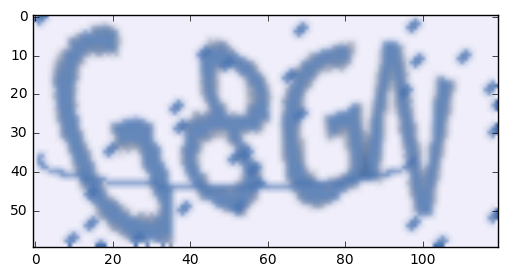

In [187]:
plt.imshow(x[0])

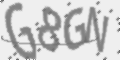

In [215]:
img.convert("L")

In [214]:
import PIL
img = PIL.Image.fromarray(x[0])
img = cv.fromarray(img)
ths, process = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

In [221]:
img = cv2.fromarray(x[0])
plt.imshow(img)

AttributeError: module 'cv2.cv2' has no attribute 'fromarray'